Based on these posts: 
* https://medium.com/@chrisfotache/text-classification-in-python-pipelines-nlp-nltk-tf-idf-xgboost-and-more-b83451a327e0
* https://github.com/keisukeirie/Amazon_review_helpfulness_prediction
* https://stackabuse.com/text-classification-with-bert-tokenizer-and-tf-2-0-in-python/
* https://towardsdatascience.com/simple-bert-using-tensorflow-2-0-132cb19e9b22

In [ ]:
!pip install -q boto3

In [40]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

In [41]:
!head ./amazon20000.csv

In [42]:
df = pd.read_csv('amazon20000.csv')
df.shape

(19742, 15)

In [43]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


# Drop any NaNs

In [44]:
df.shape

(19742, 15)

In [45]:
df.isna().values.any()

True

In [46]:
df_cleaned_and_filtered = df.dropna()
df_cleaned_and_filtered = df_cleaned_and_filtered.reset_index()
df_cleaned_and_filtered.shape

(19741, 16)

In [47]:
df_cleaned_and_filtered = df_cleaned_and_filtered.query('helpful_votes > 0')
df_cleaned_and_filtered.shape

(2019, 16)

In [48]:
df_cleaned_and_filtered.head(5)

,index,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
2,2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
5,5,US,4772040,R1HCST57W334KN,B0112OSOQE,38517795,Rick and Morty Season 2,Digital_Video_Download,5,5,6,N,Y,Best show on TV right now,If you don't like this show. Go back to your n...,2015-08-31
6,6,US,12910040,R32BUTYQS1ZJBQ,B000NPE5SA,373323715,Africa Screams,Digital_Video_Download,4,1,1,N,Y,Very funny. A typical mid 50's comedy,Very funny. A typical mid 50's comedy.,2015-08-31
18,18,US,47856888,R1ZHHD1GTHGMNK,B005U9RM0W,728197314,Grimm Season 1,Digital_Video_Download,4,1,1,N,Y,If you're a sucker for supernatural series the...,If you're a sucker for supernatural series the...,2015-08-31
55,55,US,52684121,R203639GCLF7XV,B00MYLVPFM,773772186,Amazing Race 8,Digital_Video_Download,1,5,5,N,Y,Like many other viewers I felt the Family edit...,Like many other viewers I felt the Family edit...,2015-08-31


In [49]:
df_cleaned_and_filtered['pct_helpful_votes'] = df_cleaned_and_filtered['helpful_votes'] / df_cleaned_and_filtered['total_votes']
df_cleaned_and_filtered.shape

(2019, 17)

In [50]:
df_cleaned_and_filtered.head(5)

,index,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,pct_helpful_votes
2,2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31,0.944444
5,5,US,4772040,R1HCST57W334KN,B0112OSOQE,38517795,Rick and Morty Season 2,Digital_Video_Download,5,5,6,N,Y,Best show on TV right now,If you don't like this show. Go back to your n...,2015-08-31,0.833333
6,6,US,12910040,R32BUTYQS1ZJBQ,B000NPE5SA,373323715,Africa Screams,Digital_Video_Download,4,1,1,N,Y,Very funny. A typical mid 50's comedy,Very funny. A typical mid 50's comedy.,2015-08-31,1.000000
18,18,US,47856888,R1ZHHD1GTHGMNK,B005U9RM0W,728197314,Grimm Season 1,Digital_Video_Download,4,1,1,N,Y,If you're a sucker for supernatural series the...,If you're a sucker for supernatural series the...,2015-08-31,1.000000
55,55,US,52684121,R203639GCLF7XV,B00MYLVPFM,773772186,Amazing Race 8,Digital_Video_Download,1,5,5,N,Y,Like many other viewers I felt the Family edit...,Like many other viewers I felt the Family edit...,2015-08-31,1.000000


In [51]:
df_cleaned_and_filtered['is_helpful'] = df_cleaned_and_filtered['pct_helpful_votes'] > 0.75
df_cleaned_and_filtered.head(5)

,index,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,pct_helpful_votes,is_helpful
2,2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31,0.944444,True
5,5,US,4772040,R1HCST57W334KN,B0112OSOQE,38517795,Rick and Morty Season 2,Digital_Video_Download,5,5,6,N,Y,Best show on TV right now,If you don't like this show. Go back to your n...,2015-08-31,0.833333,True
6,6,US,12910040,R32BUTYQS1ZJBQ,B000NPE5SA,373323715,Africa Screams,Digital_Video_Download,4,1,1,N,Y,Very funny. A typical mid 50's comedy,Very funny. A typical mid 50's comedy.,2015-08-31,1.000000,True
18,18,US,47856888,R1ZHHD1GTHGMNK,B005U9RM0W,728197314,Grimm Season 1,Digital_Video_Download,4,1,1,N,Y,If you're a sucker for supernatural series the...,If you're a sucker for supernatural series the...,2015-08-31,1.000000,True
55,55,US,52684121,R203639GCLF7XV,B00MYLVPFM,773772186,Amazing Race 8,Digital_Video_Download,1,5,5,N,Y,Like many other viewers I felt the Family edit...,Like many other viewers I felt the Family edit...,2015-08-31,1.000000,True


In [52]:
df_cleaned_and_filtered['is_positive_sentiment'] = (df_cleaned_and_filtered['star_rating'] >= 4).astype(int)
df_cleaned_and_filtered.head(5)

,index,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,pct_helpful_votes,is_helpful,is_positive_sentiment
2,2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31,0.944444,True,1
5,5,US,4772040,R1HCST57W334KN,B0112OSOQE,38517795,Rick and Morty Season 2,Digital_Video_Download,5,5,6,N,Y,Best show on TV right now,If you don't like this show. Go back to your n...,2015-08-31,0.833333,True,1
6,6,US,12910040,R32BUTYQS1ZJBQ,B000NPE5SA,373323715,Africa Screams,Digital_Video_Download,4,1,1,N,Y,Very funny. A typical mid 50's comedy,Very funny. A typical mid 50's comedy.,2015-08-31,1.000000,True,1
18,18,US,47856888,R1ZHHD1GTHGMNK,B005U9RM0W,728197314,Grimm Season 1,Digital_Video_Download,4,1,1,N,Y,If you're a sucker for supernatural series the...,If you're a sucker for supernatural series the...,2015-08-31,1.000000,True,1
55,55,US,52684121,R203639GCLF7XV,B00MYLVPFM,773772186,Amazing Race 8,Digital_Video_Download,1,5,5,N,Y,Like many other viewers I felt the Family edit...,Like many other viewers I felt the Family edit...,2015-08-31,1.000000,True,0


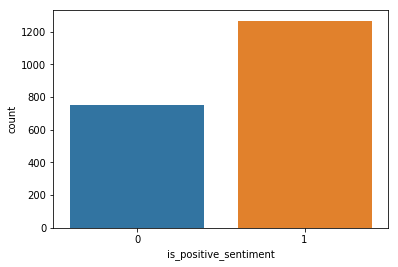

In [53]:
import seaborn as sns

sns.countplot(x='is_positive_sentiment', data=df_cleaned_and_filtered)


## Balance the dataset

In [54]:
from sklearn.utils import resample

is_negative_sentiment_df = df_cleaned_and_filtered.query('is_positive_sentiment == 0')
is_positive_sentiment_df = df_cleaned_and_filtered.query('is_positive_sentiment == 1')

is_positive_downsampled_df = resample(is_positive_sentiment_df,
                                      replace = False, # sample without replacement
                                      n_samples = len(is_negative_sentiment_df), # match minority n
                                      random_state = 27) # reproducible results

df_cleaned_and_filtered = pd.concat([is_negative_sentiment_df, is_positive_downsampled_df])


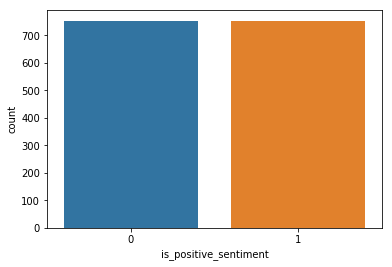

In [55]:
sns.countplot(x='is_positive_sentiment', data=df_cleaned_and_filtered)


In [56]:
X = df_cleaned_and_filtered[['review_body']]
y = df_cleaned_and_filtered['is_positive_sentiment']

print('X.shape:  {}'.format(X.shape))
print('y.shape:  {}'.format(y.shape))

X.shape:  (1506, 1)
y.shape:  (1506,)


In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

In [58]:
X_train.shape

(1355, 1)

In [59]:
X_train.head(5)

,review_body
7893,Fun movie for the entire family. My son loves...
13059,Mythbusters is always good and I find that I s...
12479,Is not a spider man movie!!
15557,Dan Mercer (Ben Rosenfield) and Melanie Clark ...
9195,"This is a very important movie, especially if ..."


In [60]:
X_test.shape

(151, 1)

In [61]:
X_test.head(5)

,review_body
7597,Like too many of the French films selected by ...
17759,l rate zombie movies very low and the plot is ...
369,I highly recommend &#34;A Beginner’s Guide to ...
13434,We shut it off after the first half hour or so.
10338,Romanticized story about a brilliant (accordin...


In [69]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]

In [70]:
import nltk
import re
def Tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    porter_stemmer=nltk.PorterStemmer()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [71]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import SGDClassifier

feature_union = FeatureUnion([
        ('body', Pipeline([
            ('body_text_selector', TextSelector('review_body')),
            ('tfidf_vectorizer', TfidfVectorizer(tokenizer=Tokenizer, stop_words="english",
                     min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
        ]))
])

X_train_transformed = feature_union.fit_transform(X_train)
X_train_transformed.shape

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not

(1355, 300)

In [72]:
# For CSV training, the XGBoost built-in algorithm assumes that the target variable is in the first column and that the CSV does not have a header record.

X_train_new_pd = pd.DataFrame(X_train_transformed)
X_train_new_pd.insert(0, 'is_positive_sentiment', y_train)
X_train_new_pd = X_train_new_pd.fillna(0)

#cols = list(train_df)
#cols.insert(0, cols.pop(cols.index('OUTPUT_LABEL')))
#train_df = train_df.loc[:, cols]

X_train_new_pd.head(5)


,is_positive_sentiment,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,0.0,0.159004,0.199727,-0.050667,0.164099,-0.030212,-0.010093,0.023277,-0.028741,-0.030596,...,-0.006874,-0.000834,-0.009423,-0.037907,-0.014301,0.019246,0.007047,0.038370,-0.030456,-0.009299
1,0.0,0.153646,-0.045517,0.250567,0.055565,-0.041954,0.012298,-0.044607,-0.054643,-0.114635,...,-0.028824,0.015275,0.031076,0.015620,-0.008546,-0.007388,0.006128,-0.056117,-0.022343,0.013905
2,1.0,0.019527,-0.004676,-0.005998,-0.011110,-0.000256,-0.010666,0.003687,-0.000341,0.011381,...,-0.014249,-0.006609,-0.031707,0.011874,0.010235,0.048067,-0.010436,-0.019199,0.009205,0.012855
3,0.0,0.337229,-0.131709,-0.058065,-0.116361,-0.085075,-0.001721,-0.051637,-0.040421,0.241220,...,-0.021995,-0.029778,0.033144,0.025770,-0.020943,0.038155,-0.017942,0.005068,-0.010059,-0.006935
4,0.0,0.104284,-0.014138,-0.010007,0.197581,0.164413,-0.043899,0.045514,0.012646,0.030929,...,0.013392,-0.026259,-0.005501,0.066048,0.035446,-0.012330,0.005325,-0.038979,0.046382,0.001928


In [66]:
X_train_new_pd.to_csv('train_transformed.csv', index=False, header=False)

In [77]:
X_test_transformed = feature_union.fit_transform(X_test)
X_test_transformed.shape

(151, 151)

In [74]:
# For CSV training, the XGBoost built-in algorithm assumes that the target variable is in the first column and that the CSV does not have a header record.

X_test_new_pd = pd.DataFrame(X_test_transformed)
X_test_new_pd.insert(0, 'is_positive_sentiment', y_test)
X_test_new_pd = X_test_new_pd.fillna(0)

X_test_new_pd.head(5)


,is_positive_sentiment,0,1,2,3,4,5,6,7,8,...,141,142,143,144,145,146,147,148,149,150
0,0.0,0.012943,0.065632,0.120328,-0.055616,-0.076050,-0.007661,-0.053714,0.013411,-0.011845,...,0.000202,0.012228,0.003963,0.004695,0.000165,0.000748,0.001415,5.659422e-62,-0.000000e+00,4.627242e-66
1,0.0,0.005051,0.051163,0.019149,-0.013992,-0.011863,-0.003587,-0.084042,-0.044274,0.009556,...,0.001930,0.005990,0.000691,0.001893,-0.000079,0.000358,0.002701,-7.671501e-32,1.375597e-33,-2.194478e-44
2,0.0,0.006868,0.026743,0.074949,-0.032439,-0.033993,0.000560,0.013175,-0.068350,0.008797,...,-0.000871,0.002492,-0.001039,-0.000455,0.000142,0.000756,-0.000236,-8.522142e-33,2.893213e-34,-1.497768e-44
3,0.0,0.000898,0.007507,0.019348,-0.007959,-0.013498,0.000308,-0.006031,-0.048860,0.012214,...,-0.000306,0.001514,-0.003205,-0.000288,-0.000142,0.000007,0.000101,3.151015e-32,-7.353729e-34,2.928343e-44
4,0.0,0.009256,0.030994,0.090871,0.076059,-0.004716,0.000474,0.020347,-0.037027,0.014173,...,0.009385,0.005587,-0.030805,0.000226,0.000284,0.000468,-0.000100,-1.764270e-31,-9.733446e-35,-1.799434e-44


In [ ]:
X_test_new_pd.to_csv('validation_transformed.csv', index=False, header=False)

In [78]:
prefix = 'sagemaker/xgboost/data'

# The Amazon SageMaker implementation of XGBoost supports CSV formats for training and inference
# For Training ContentType, valid inputs `text/csv`.

train_data_uri = sess.upload_data(path="train_transformed.csv", key_prefix=prefix + "/training")
#validation_data_uri = sess.upload_data(path="validation_transformed.csv", key_prefix=prefix + "/validation")

print(train_data_uri)
#print(validation_data_uri)

s3_input_train_data = sagemaker.s3_input(s3_data=train_data_uri, content_type='text/csv')
#s3_input_validation_data = sagemaker.s3_input(s3_data=validation_data_uri, content_type='text/csv')


s3://sagemaker-us-east-1-835319576252/sagemaker/xgboost/data/training/train_transformed.csv


In [79]:
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri 

# get the URI for new container
builtin_container_uri = get_image_uri(region_name=region,                                
                                  repo_name='xgboost', 
                                  repo_version='0.90-2')

model_output_path = 's3://{}/sagemaker/xgboost/training-runs'.format(bucket)

xgb_estimator = sagemaker.estimator.Estimator(image_name=builtin_container_uri, 
                                              role=role, 
                                              hyperparameters={'num_round': 1,
                                                               'max_depth': 5},
                                                               #'learning_rate': 0.01},
                                              train_instance_count=1, 
                                              train_instance_type='ml.m4.xlarge', 
                                              output_path=model_output_path, 
                                              sagemaker_session=sess);
xgb_estimator.fit({'train': s3_input_train_data,
                   #'validation': s3_input_validation_data
                  }
                  #, wait=False
                 )

2020-03-01 04:54:25 Starting - Starting the training job...
2020-03-01 04:54:27 Starting - Launching requested ML instances......
2020-03-01 04:55:28 Starting - Preparing the instances for training...
2020-03-01 04:56:19 Downloading - Downloading input data...
2020-03-01 04:56:49 Training - Downloading the training image...
2020-03-01 04:57:23 Uploading - Uploading generated training model
2020-03-01 04:57:23 Completed - Training job completed
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[04:57:12] 1355x300 matrix with 406500 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Single node training.
INFO:root:Train matrix has 1355 rows
[0]#011train-rmse:

In [80]:
training_job_name = xgb_estimator.latest_training_job.name
print('training_job_name:  {}'.format(training_job_name))

training_job_name:  sagemaker-xgboost-2020-03-01-04-54-25-710


In [ ]:
# TODO:  This is broken
#from sagemaker.xgboost import XGBoost

#xgb_estimator = XGBoost.attach(training_job_name=training_job_name)

# Deploy Endpoint

In [ ]:
xgb_endpoint_name = prefix + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

xgb_predictor = xgb_estimator.deploy(
                     initial_instance_count=1, 
                     instance_type='ml.m4.xlarge',
                     endpoint_name=xgb_endpoint_name)

In [ ]:
predictions, raw_outputs = model.predict(["""Very funny. A typical mid 50's comedy."""])
print('Predictions: {}'.format(predictions))
print('Raw outputs: {}'.format(raw_outputs))

In [ ]:
predictions, raw_outputs = bert_model.predict(["""That movie was absolutely awful."""])
print('Predictions: {}'.format(predictions))
print('Raw outputs: {}'.format(raw_outputs))